In [180]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
import controllers
import numpy as np
import json
import pandas as pd
import controllers
import synthetics
import os
import datetime as dt

In [181]:
def clamp(x, x_min, x_max):
    """Clamps number x between x_min and x_max"""
    if x > x_max:
        return x_max
    if x < x_min:
        return x_min
    return x

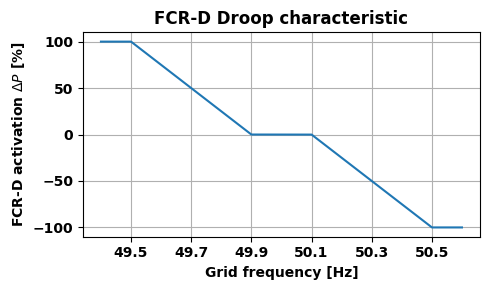

In [182]:
droop = controllers.DroopController(0.4e-2,50,0.1)
fs = np.linspace(49.4,50.6,1000)
activation = [clamp(droop.update(f),-100,100) for f in fs]
plt.figure(figsize=(5,3))
plt.plot(fs,activation)
plt.title('FCR-D Droop characteristic',weight='bold')
plt.xlabel('Grid frequency [Hz]',weight='bold')
plt.ylabel(r'FCR-D activation $\Delta P$ [%]',weight='bold')
plt.xticks([49.5,49.7,49.9,50.1,50.3,50.5],weight='bold')
plt.yticks(weight='bold')
plt.grid(True)
plt.tight_layout()

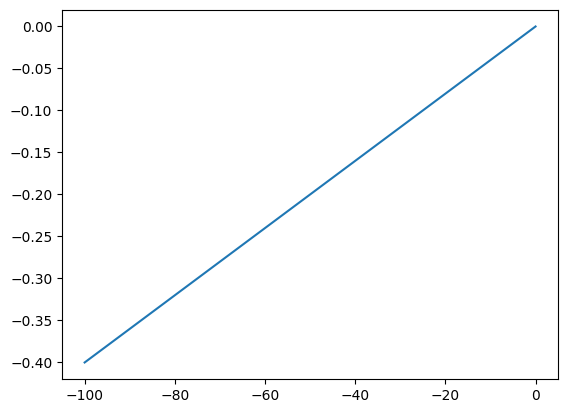

In [183]:
plt.figure()
R = 0.4e-2
activations = np.linspace(0,-100,1000)
fs = R*activations
plt.plot(activations,fs)

In [184]:
filepath = 'tests/' + sorted(os.listdir('tests/'))[-1]
with open(filepath) as file:
    data = [json.loads(line) for line in file]

df = pd.DataFrame.from_records(data)
start = dt.datetime.fromtimestamp(df.loc[df['type']=='start','value'].iloc[0]) - dt.timedelta(hours=1)
stop = dt.datetime.fromtimestamp(df['time_stamp'].iloc[-1]) - dt.timedelta(hours=1)
df = df.loc[df['type'] != 'start']
df['cols'] = (np.array(df['type'].values) + '@' + df['unit'].values)
df_pivot = df.pivot_table(values="value", columns="cols", index="time_stamp")
df_pivot = df_pivot.interpolate(method="linear")
df_pivot.index = pd.to_datetime(df_pivot.index, unit="s")
# Resample the data
df_resampled = df_pivot.resample("s").mean()

# Interpolate the measurements
df_resampled = df_resampled.interpolate()


In [185]:
test = synthetics.FastRampTest(start)
active_bid = 1.5
ts = np.arange(start,stop,dt.timedelta(seconds=0.1)).astype(dt.datetime)
fs = np.array([test.measure_frequency(t) for t in ts])
dfs = fs-50.1
R = 0.4/active_bid
dPs = np.array([clamp(-df/R,-active_bid,0) for df in dfs])

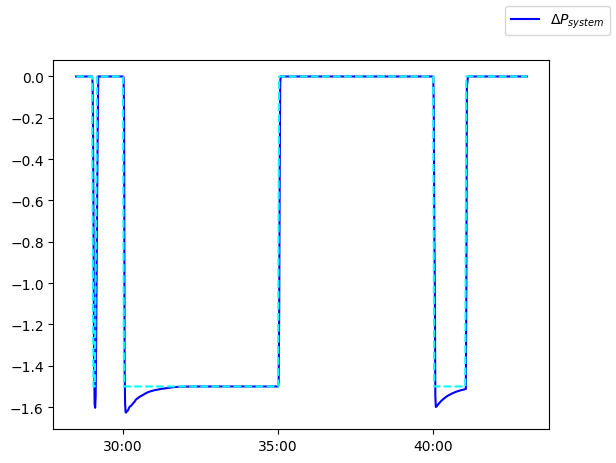

In [186]:
fig,ax1 = plt.subplots()

ax1.plot(df_resampled.index,df_resampled['delta P system@supervisor'],label = r'$\Delta P_{system}$',color='b')
ax1.plot(ts,dPs, color='cyan',linestyle='--')
#ax1.set_xlim(ts[0],ts[8000])
#ax2 = ax1.twinx()
#ax2.plot(df_resampled.index,df_resampled['frequency@supervisor'],label = r'Frequency',color='r')
#ax2.plot(ts,fs,linestyle='--',color='r')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%M:%S'))
fig.legend()

In [187]:
df_resampled.columns

Index(['capacity@pi_1', 'capacity@pi_2', 'delta P supervisor@supervisor',
       'delta P system@supervisor', 'delta P@pi_1', 'delta P@pi_2',
       'droop constant@pi_1', 'droop constant@pi_2', 'frequency@supervisor'],
      dtype='object', name='cols')

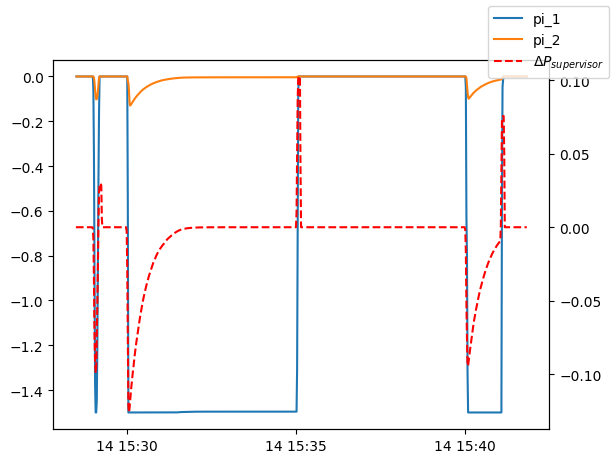

In [188]:
idxs = [c.split('@')[0] == 'delta P' for c in df_resampled.columns]
#df_resampled.iloc[0:800,idxs].plot()
fig, ax1 = plt.subplots()
for c in df_resampled.iloc[:,idxs]:
    ax1.plot(df_resampled.index[0:800],df_resampled[c].iloc[0:800],label = str(c).split('@')[1])
ax2 = ax1.twinx()
ax2.plot(df_resampled.index[0:800],df_resampled['delta P supervisor@supervisor'][0:800],linestyle = '--',color='red',label = r'$\Delta P_{supervisor}$')
fig.legend()

    

Text(0.5, 0.98, 'Initial test for Ki tuning')

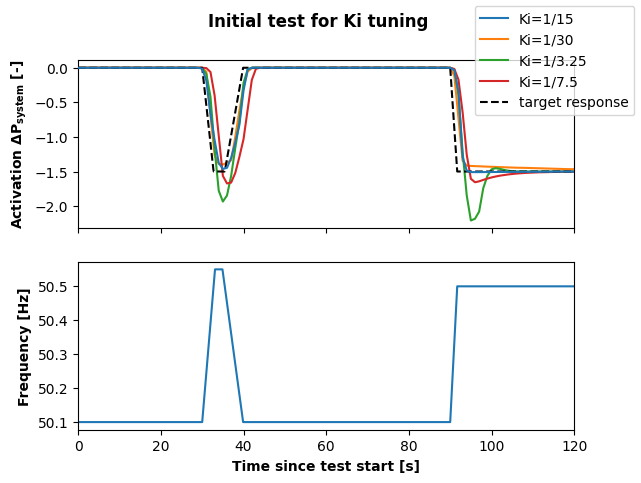

In [202]:
#filepath = 'tests/' + sorted(os.listdir('tests/'))[-1]
fig, axs = plt.subplots(2,1,sharex=True)
for f in os.listdir('saved/'):
    if not f.__contains__('ki'):
        continue
    with open('saved/'+f) as file:
        data = [json.loads(line) for line in file]

    df = pd.DataFrame.from_records(data)
    start = dt.datetime.fromtimestamp(df.loc[df['type']=='start','value'].iloc[0]) - dt.timedelta(hours=1)
    stop = dt.datetime.fromtimestamp(df['time_stamp'].iloc[-1]) - dt.timedelta(hours=1)
    df = df.loc[df['type'] != 'start']
    df['cols'] = (np.array(df['type'].values) + '@' + df['unit'].values)
    df_pivot = df.pivot_table(values="value", columns="cols", index="time_stamp")
    df_pivot = df_pivot.interpolate(method="linear")
    df_pivot.index = pd.to_datetime(df_pivot.index, unit="s")
    # Resample the data
    df_resampled = df_pivot.resample("s").mean()

    # Interpolate the measurements
    df_resampled = df_resampled.interpolate()
    df_resampled['offset'] = (df_resampled.index - df_resampled.index[0]).total_seconds()
    label = 'Ki=1/'+f[2:-5].replace('_','.')
    if '15' in f:
        axs[0].plot(df_resampled['offset'],df_resampled['delta P system@supervisor'],label=label,zorder=100)
    else:
        axs[0].plot(df_resampled['offset'],df_resampled['delta P system@supervisor'],label=label)

start = dt.datetime.now()

test = synthetics.FastRampTest(start)
active_bid = 1.5
ts = np.arange(start,start + dt.timedelta(seconds=200),dt.timedelta(seconds=0.1)).astype(dt.datetime)
toffs = np.array([(t-start).total_seconds() for t in ts])
fs = np.array([test.measure_frequency(t) for t in ts])
dfs = fs-50.1
R = 0.4/active_bid
dPs = np.array([clamp(-df/R,-active_bid,0) for df in dfs])
axs[1].plot(toffs,fs)

axs[0].plot(toffs,dPs,color='black',linestyle='--', label = 'target response')
axs[0].set_xlim(0,120)
fig.legend()
axs[0].set_ylabel(r'Activation $\mathbf{\Delta P_{system}}$ [-]',weight='bold')
axs[1].set_ylabel('Frequency [Hz]',weight='bold')
axs[1].set_xlabel('Time since test start [s]',weight='bold')
fig.suptitle('Initial test for Ki tuning',weight='bold')

Text(0.5, 0.98, 'Synthetic fast ramp test')

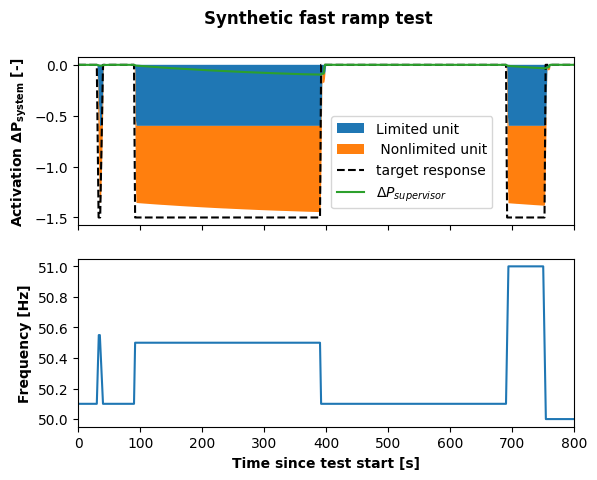

In [226]:
#filepath = 'saved/ki15.json'
filepath = 'tests/141125,202933.json'
fig, axs = plt.subplots(2,1,sharex=True)
with open(filepath) as file:
    data = [json.loads(line) for line in file]

df = pd.DataFrame.from_records(data)
start = dt.datetime.fromtimestamp(df.loc[df['type']=='start','value'].iloc[0]) - dt.timedelta(hours=1)
stop = dt.datetime.fromtimestamp(df['time_stamp'].iloc[-1]) - dt.timedelta(hours=1)
df = df.loc[df['type'] != 'start']
df['cols'] = (np.array(df['type'].values) + '@' + df['unit'].values)
df_pivot = df.pivot_table(values="value", columns="cols", index="time_stamp")
df_pivot = df_pivot.interpolate(method="linear")
df_pivot.index = pd.to_datetime(df_pivot.index, unit="s")
# Resample the data
df_resampled = df_pivot.resample("s").mean()

# Interpolate the measurements
df_resampled = df_resampled.interpolate()
df_resampled['offset'] = (df_resampled.index - df_resampled.index[0]).total_seconds()
axs[0].stackplot(df_resampled['offset'],df_resampled['delta P@pi_1'],df_resampled['delta P@pi_2'],labels=['Limited unit',' Nonlimited unit'])

start = dt.datetime.now()

test = synthetics.FastRampTest(start)
active_bid = 1.5
ts = np.arange(start,start + dt.timedelta(seconds=800),dt.timedelta(seconds=0.1)).astype(dt.datetime)
toffs = np.array([(t-start).total_seconds() for t in ts])
fs = np.array([test.measure_frequency(t) for t in ts])
dfs = fs-50.1
R = 0.4/active_bid
dPs = np.array([clamp(-df/R,-active_bid,0) for df in dfs])


axs[0].plot(toffs,dPs,color='black',linestyle='--', label = 'target response')
axs[0].plot(df_resampled['offset'],df_resampled['delta P supervisor@supervisor'], label = r'$\Delta P_{supervisor}$')
axs[0].set_xlim(0,800)
axs[0].legend(loc=(0.51,0.1))
axs[0].set_ylabel(r'Activation $\mathbf{\Delta P_{system}}$ [-]',weight='bold')
axs[1].plot(toffs,fs,label = 'frequency')
axs[1].set_ylabel('Frequency [Hz]',weight='bold')
axs[1].set_xlabel('Time since test start [s]',weight='bold')
fig.suptitle('Synthetic fast ramp test',weight='bold')

Text(0.5, 0.98, 'Fast ramp test with different inverter delays')

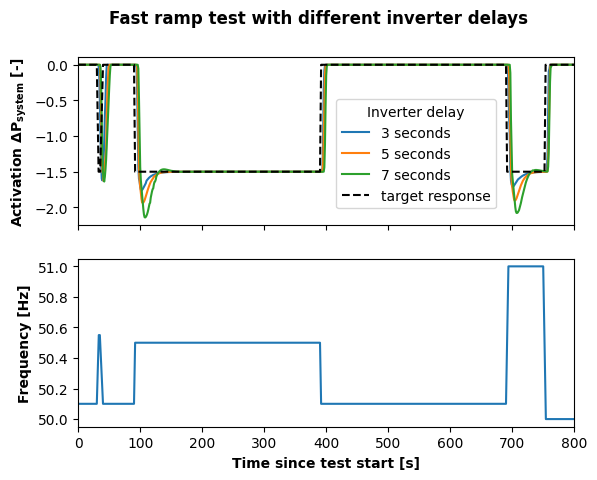

In [222]:
#filepath = 'tests/' + sorted(os.listdir('tests/'))[-1]
fig, axs = plt.subplots(2,1,sharex=True)
for f in os.listdir('saved/'):
    if not f.__contains__('seconddelay'):
        continue
    with open('saved/'+f) as file:
        data = [json.loads(line) for line in file]

    df = pd.DataFrame.from_records(data)
    start = dt.datetime.fromtimestamp(df.loc[df['type']=='start','value'].iloc[0]) - dt.timedelta(hours=1)
    stop = dt.datetime.fromtimestamp(df['time_stamp'].iloc[-1]) - dt.timedelta(hours=1)
    df = df.loc[df['type'] != 'start']
    df['cols'] = (np.array(df['type'].values) + '@' + df['unit'].values)
    df_pivot = df.pivot_table(values="value", columns="cols", index="time_stamp")
    df_pivot = df_pivot.interpolate(method="linear")
    df_pivot.index = pd.to_datetime(df_pivot.index, unit="s")
    # Resample the data
    df_resampled = df_pivot.resample("s").mean()

    # Interpolate the measurements
    df_resampled = df_resampled.interpolate()
    df_resampled['offset'] = (df_resampled.index - df_resampled.index[0]).total_seconds()
    label = f[0]+' seconds'
    axs[0].plot(df_resampled['offset'],df_resampled['delta P system@supervisor'],label=label)

start = dt.datetime.now()

test = synthetics.FastRampTest(start)
active_bid = 1.5
ts = np.arange(start,start + dt.timedelta(seconds=800),dt.timedelta(seconds=0.1)).astype(dt.datetime)
toffs = np.array([(t-start).total_seconds() for t in ts])
fs = np.array([test.measure_frequency(t) for t in ts])
dfs = fs-50.1
R = 0.4/active_bid
dPs = np.array([clamp(-df/R,-active_bid,0) for df in dfs])
axs[1].plot(toffs,fs)

axs[0].plot(toffs,dPs,color='black',linestyle='--', label = 'target response')
axs[0].set_xlim(0,800)
axs[0].legend(loc=(0.52,0.1),title='Inverter delay')
axs[0].set_ylabel(r'Activation $\mathbf{\Delta P_{system}}$ [-]',weight='bold')
axs[1].set_ylabel('Frequency [Hz]',weight='bold')
axs[1].set_xlabel('Time since test start [s]',weight='bold')
fig.suptitle('Fast ramp test with different inverter delays',weight='bold')